In [235]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import os
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Verify GPU is detected

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Force TF to only allocate memory as needed on the GPU, otherwise TF attempts to allocate all the memory incase it needs it.
# TF using all the memory leads to the "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize," error.
# Note that if RTX Voice (or other GPU memory heavy application) isn't running then this isn't needed.
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Training parameters

In [3]:
BATCH_SIZE = 32
EPOCHS = 64

# Image size in pixels.
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Number of images in the training set.
N_TRAIN = 481

# Number of image classes / categories.
CLASS_COUNT = 9

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# Extra note added to the details file.
EXTRA_NOTES = "Zoom range = 20"

# Load Data

In [4]:
# Directories of data, each catergory / class of data is in a seperate folder.
# TRAINING_DIR = "training_data/training"
# VALIDATION_DIR = "training_data/validation"
TRAINING_DIR = "reduced_training_data/training"
VALIDATION_DIR = "reduced_training_data/validation"

In [5]:
# Rescale here refers to scaling the pixel values from a range of [0, 255] to a range of [0, 1].
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen_batches = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TRAINING_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="grayscale",
                                                           class_mode='categorical',
                                                           )

Found 481 images belonging to 9 classes.


In [7]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=VALIDATION_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="grayscale",
                                                              class_mode='categorical')

Found 117 images belonging to 9 classes.


# Model Layers

In [8]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(CLASS_COUNT, activation='softmax')
])



# Optimizer

In [9]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# Compile Model

In [10]:
model.compile(optimizer=get_optimizer(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Tensorboard Logging + Model Summary 

In [11]:
log_dir = "logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31490176  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

# Setup Checkpointing the Model

In [13]:
def get_details():
    DETAILS = "batch_size={}_epochs={}_img=({},{})".format(BATCH_SIZE, EPOCHS, IMG_HEIGHT, IMG_WIDTH)
    return DETAILS

In [14]:
TIMESTAMP = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

BASE_CHECKPOINT_PATH = "checkpoints"

CHECKPOINT_FILE_NAME = "cp-{epoch:04d}.ckpt"
CHECKPOINT_PATH = os.path.join(BASE_CHECKPOINT_PATH, TIMESTAMP, CHECKPOINT_FILE_NAME)
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

os.makedirs(CHECKPOINT_DIR)

DETAIL_FILE_NAME = "details.txt"

details_file = open(os.path.join(CHECKPOINT_DIR, DETAIL_FILE_NAME), "w")
details_file.write(TIMESTAMP + "\n")
details_file.write(get_details() + "\n")
details_file.write(EXTRA_NOTES)
details_file.close()

MODEL_FINAL_SAVE_PATH = os.path.join(BASE_CHECKPOINT_PATH, "final_model.h5")

In [15]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
#                                                  save_weights_only=True,
                                                 verbose=1,
                                                 period=8
                                                )

In [16]:
model.save_weights(CHECKPOINT_PATH.format(epoch=0))

# Train the model

In [17]:
history = model.fit(train_data_gen_batches, epochs=EPOCHS, validation_data = val_data_gen, verbose = 1, callbacks=[cp_callback, tensorboard_callback])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 4 steps
Epoch 1/64
16/16 [==============================] - 11s 717ms/step - loss: 0.7399 - accuracy: 0.8649 - val_loss: 0.7378 - val_accuracy: 0.8889
Epoch 2/64
16/16 [==============================] - 11s 662ms/step - loss: 0.7380 - accuracy: 0.8889 - val_loss: 0.7379 - val_accuracy: 0.8889
Epoch 3/64
16/16 [==============================] - 11s 660ms/step - loss: 0.7379 - accuracy: 0.8887 - val_loss: 0.7380 - val_accuracy: 0.8889
Epoch 4/64
16/16 [==============================] - 11s 661ms/step - loss: 0.7375 - accuracy: 0.8868 - val_loss: 0.7381 - val_accuracy: 0.8889
Epoch 5/64
16/16 [==============================] - 11s 660ms/step - loss: 0.7377 - accuracy: 0.8870 - val_loss: 0.7380 - val_accuracy: 0.8889
Epoch 6/64
16/16 [==============================] - 11s 660ms/step - loss: 0.7377 - accuracy: 0.8873 - val_loss: 0.7380 - val_accuracy: 0.8889
Epoch 7/64
16/16 [==============================] -

16/16 [==============================] - 11s 673ms/step - loss: 0.6979 - accuracy: 0.9191 - val_loss: 0.7138 - val_accuracy: 0.8993
Epoch 46/64
16/16 [==============================] - 11s 681ms/step - loss: 0.6959 - accuracy: 0.9233 - val_loss: 0.7116 - val_accuracy: 0.8993
Epoch 47/64
16/16 [==============================] - 11s 676ms/step - loss: 0.7021 - accuracy: 0.9196 - val_loss: 0.7115 - val_accuracy: 0.9031
Epoch 48/64
15/16 [===========================>..] - ETA: 0s - loss: 0.7027 - accuracy: 0.9201
Epoch 00048: saving model to checkpoints\20-06-2020-14-30-32\cp-0048.ckpt
INFO:tensorflow:Assets written to: checkpoints\20-06-2020-14-30-32\cp-0048.ckpt\assets
16/16 [==============================] - 13s 782ms/step - loss: 0.7027 - accuracy: 0.9191 - val_loss: 0.7116 - val_accuracy: 0.9079
Epoch 49/64
16/16 [==============================] - 11s 674ms/step - loss: 0.6997 - accuracy: 0.9282 - val_loss: 0.7114 - val_accuracy: 0.9098
Epoch 50/64
16/16 [=============================

# Save the Model 

In [19]:
model.save("final_model.h5")

# Display Results

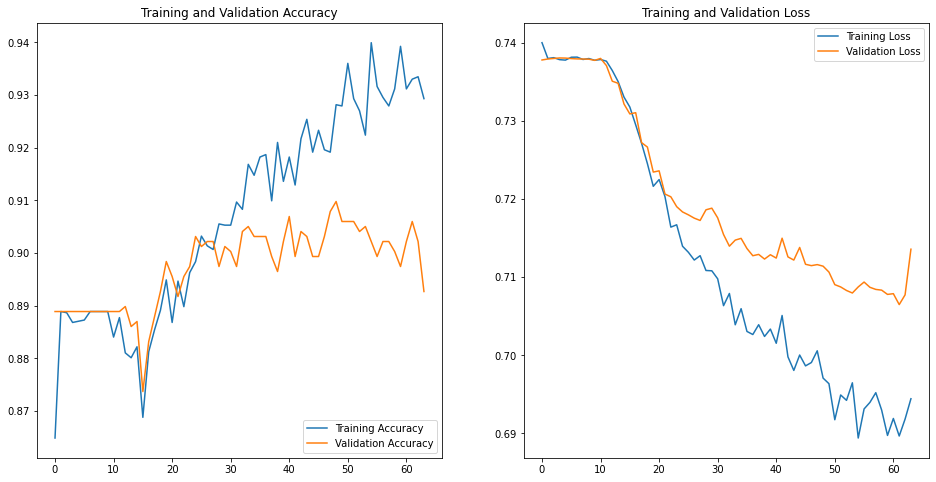

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

file_name = "graph.png"

plt.savefig(os.path.join(CHECKPOINT_DIR, file_name))

plt.show()

# Make some test predictions

In [181]:
TEST_DIR = "reduced_training_data/test"
TEST_CLASSES = ["707-320", "737-800", "777-200", "a330-200", "bae 146-300", "c-130", "eurofighter typhoon", "md-80", "spitfire"]

In [244]:
def plot_prediction(ax, prediction, actual, title):
    patches, texts, autotexts = ax.pie(prediction, labels=None, explode=[0.1] * 9, autopct='%1.1f%%', shadow=True)
    
    ax.set_title(title)
#     ax.axis('equal')
    ax.legend(patches, TEST_CLASSES, bbox_to_anchor=(1.4, 0.5), loc="center right")
    

In [183]:
# This function will plot images in the form of a grid with 1 row and 3 columns.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [188]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                              directory=TEST_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="grayscale",
                                                              class_mode='categorical')

Found 9 images belonging to 9 classes.


In [189]:
# plt.figure()
# test_images, _ = peek(test_data_gen)
# plotImages(test_images[:3])

In [216]:
predictions = model.predict(test_data_gen)
actual_classes = test_data_gen.classes

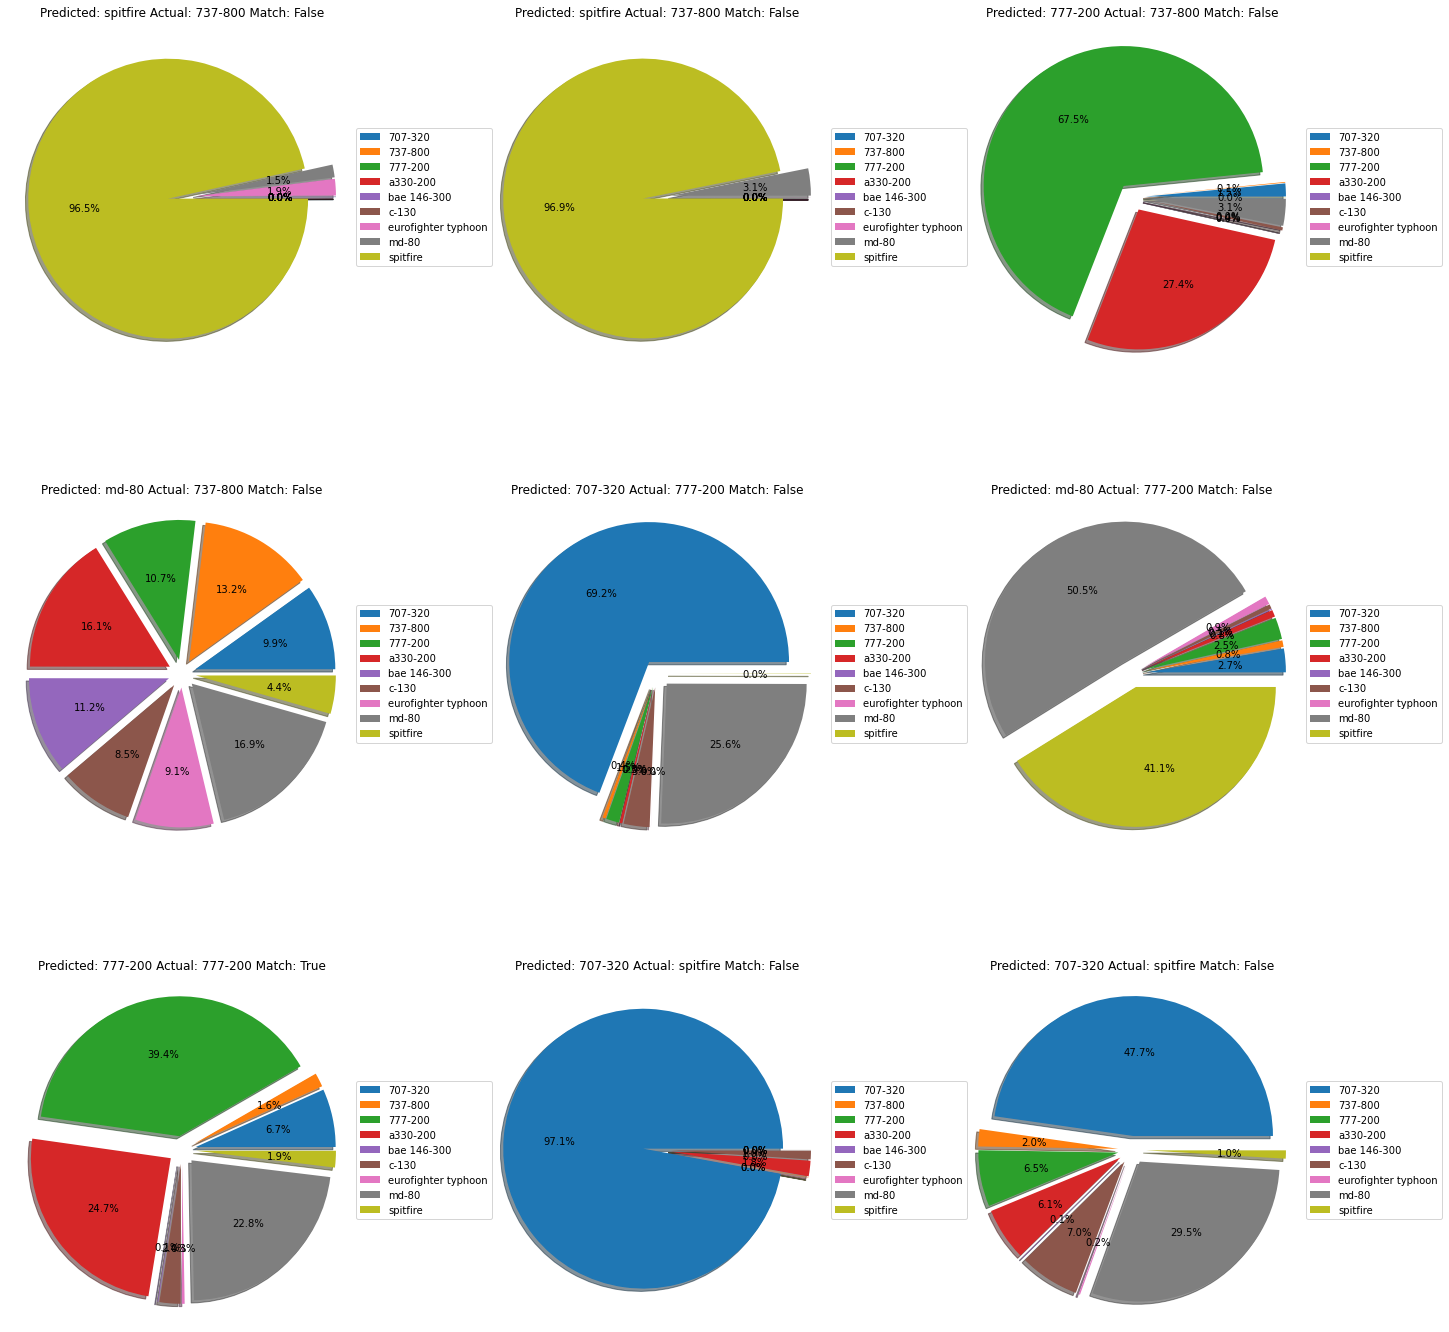

In [253]:
nrows = 3
ncol = 3

fig, ax = plt.subplots(math.ceil(len(predictions) / nrows), ncol, figsize=(20,20))

for index, predic in enumerate(predictions):
    predicted = np.argmax(predic)
    actual = actual_classes[index]
    title = "Predicted: {} Actual: {} Match: {}".format(TEST_CLASSES[predicted], TEST_CLASSES[actual], predicted==actual)
#     fig.figure(figsize=(6,24))
#     fig, ax = subplot(len(predictions), 1, index + 1)
    a = ax[int(index / nrows)][index % ncol]
    plot_prediction(a, predic, actual, title)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_results.pdf"), dpi=300, bbox_inches='tight')
plt.show()
